In [1]:
"""
Fill in the missing code. The lines with missing code have the string "#####" or '*'
"INSTRUCTIONS" comments explain how to fill in the mising code.
the outputfile.txt has the printouts from the program.
"RESULTS" comments explain what results to expect from the program.
Your results should be similar within reason, if not, re-run the program,
since we are using RandomizedSearchCV, meaning there is some randomness involved.
Actually, we added np.random.seed() to fix the results, so you can check them.

You will be filling in code in two types of models:
1. a regression model and
2. a classification model.

Most of the time, because of similarities,
you can cut and paste from one model to the other.
But in a few instances, you cannot do this, so
you need to pay attention.
Also, in some cases,
you will find a "hint" for a solution 
in one of the two scripts (regression or classification)
that you can use as inspiration for the other.

This double task gives you the opportunity to look at the results
in both regression and classification approaches.

"""

"""
So far, you have learned how to use financial criteria as scorers of regressor models.
Here we will show you how to use financial criteria as scorers of classifier models.
As you will see, this is difficult to do because Scikit-Learn is not set up to allow us to do this easily.
As a work-around, we are using search_sequence_numpy(arr,seq) to get around the difficulty.
search_sequence_numpy(arr,seq) is a pattern matching function whose purpose is 
to help us recover the true returns when all Scikit-Learn makes available is the true [0,1] classes.
The true returns are needed to calculate the financial metrics.
Unfortunately, pattern matching does make the script a lot slower.
"""

import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import fAux
import matplotlib.pyplot as plt
import seaborn as sns
import sys

global global_returns
global global_labels

np.random.seed(2) #to fix the results
rs = 2
 
file_path = 'outputfile.txt'
#saveMe = sys.stdout
# sys.stdout = open(file_path, "w")


#df = pd.read_csv('EURUSD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('GBPUSD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('NZDUSD_H3_200001030000_202107201800.csv', sep='\t')
df = pd.read_csv('USDCAD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('USDCHF_H3_200001030000_202107201800.csv', sep='\t')

df['<DATETIME>'] = pd.to_datetime(df['<DATE>'] + ' ' + df['<TIME>'])
df = df.set_index('<DATETIME>')
df.drop(['<TIME>'], axis=1, inplace=True)
df.drop(['<DATE>'], axis=1, inplace=True)

#save the close and open for white reality check
openp = df['<OPEN>'].copy() #for the case we want to enter trades at the open
#close = df['<CLOSE>'].copy() #for the case we want to enter trades at the close


#buld the best window features after the exploratory data analysis:
for n in list(range(1,21)):
    name = 'ret' + str(n)
    df[name] = df["<OPEN>"].pct_change(periods=n) #for trading with open
    #df[name] = df["<CLOSE>"].pct_change(periods=n) #for trading with close

#build date-time features
df["hour"] = df.index.hour.values
df["day"] = df.index.dayofweek.values

#build target assuming we know today's open
df['retFut1'] = df['<OPEN>'].pct_change(1).shift(-1).fillna(0) #if you enter the trade immediately after the open
#df['retFut1'] = df['<CLOSE>'].pct_change(1).shift(-1) #if you wait until the close to enter the trade
#df = np.log(df+1)

#transform the target
df['retFut1_categ'] = np.where((df['retFut1'] > 0), 1, 0)

#Since we are trading right after the open, 
#we only know yesterday's  high low close volume spread etc.
df['<HIGH>'] = df['<HIGH>'].shift(1)
df['<LOW>'] = df['<LOW>'].shift(1)
df['<CLOSE>'] = df['<CLOSE>'].shift(1)
df['<VOL>'] = df['<VOL>'].shift(1)
df['<SPREAD>'] = df['<SPREAD>'].shift(1)

#select the features (by dropping)
cols_to_drop = ["<OPEN>","<HIGH>","<LOW>","<CLOSE>","<TICKVOL>","<VOL>","<SPREAD>"]  #optional
df_filtered = df.drop(cols_to_drop, axis=1)

#distribute the df data into X inputs and y target
X = df_filtered.drop(['retFut1', 'retFut1_categ'], axis=1) 
y = df_filtered[['retFut1_categ']]

#select the samples
x_train = X.iloc[0:10000]
x_test = X.iloc[10000:12000]

y_train = y.iloc[0:10000]
y_test = y.iloc[10000:12000]

df_train = df_filtered.iloc[0:10000]
df_test = df_filtered.iloc[10000:12000]

global_returns = df['<OPEN>'].pct_change(1).shift(-1).fillna(0)
global_labels = y

In [2]:
#set up the grid search and fit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer 
from sklearn import preprocessing
import phik
from phik.report import plot_correlation_matrix
from scipy.special import ndtr
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import FunctionTransformer
# import talib as ta
import ta
from ta.trend import EMAIndicator 
import detrendPrice 
import WhiteRealityCheckFor1 
import WhiteRealityCheckFor1_accelerated
import time

# get the start time
st = time.time()


def search_sequence_numpy(arr,seq):
    """ Find sequence in an array using NumPy only.

    Parameters
    ----------    
    arr    : input 1D array
    seq    : input 1D array

    Output
    ------    
    Output : 1D Array of indices in the input array that satisfy the 
    matching of input sequence in the input array.
    In case of no match, an empty list is returned.
    https://stackoverflow.com/questions/36522220/searching-a-sequence-in-a-numpy-array
    https://archive.is/GBCln
    """
    
    # Store sizes of input array and sequence
    Na, Nseq = arr.size, seq.size

    # Range of sequence
    r_seq = np.arange(Nseq)

    # Create a 2D array of sliding indices across the entire length of input array.
    # Match up with the input sequence & get the matching starting indices.
    M = (arr[np.arange(Na-Nseq+1)[:,None] + r_seq] == seq).all(1)

    # Get the range of those indices as final output
    if M.any() >0:
        return np.where(np.convolve(M,np.ones((Nseq),dtype=int))>0)[0]
    else:
        return []         # No match found



def mean_return(y_true, y_pred):
    #this function has access to two global variables (global_labels and global_returns)
    #to help in the calculation of the model returns (multiplying mkt returns by positions derived from y_pred)
    #search_sequence_numpy searches for the index ix of the global_labels that correspond to the sequence of true lables (y_true)
    #those ix are then used to obtain the mkt returns that need to be multiplied by the positions to obtain the model returns

    ix = search_sequence_numpy(global_labels.values.flatten(), y_true) 
    mkt_returns = global_returns.values[ix] # alternative to global_returns.values[ix[0]:ix[0]+y_true.size]
    mkt_returns = mkt_returns.flatten()
    
    positions = np.where(y_pred> 0,1,-1 )
    positions = np.nan_to_num(positions, nan=0.0)
    dailyRet = positions * mkt_returns
    dailyRet = np.nan_to_num(dailyRet, nan=0.0)
    
    #val_model_returns.append(dailyRet)
    #mean_return = gmean(dailyRet+1)-1 #will use log returns instead beause...
    dailyRet = np.log(dailyRet+1)
    mean_return = np.mean(dailyRet) #GridSearchCV and RandomSearchCV use arithmetic mean
    return mean_return


In [3]:
"""
INSTRUCTIONS
Following the pattern of mean_return above,
modify profit_ratio so as to obtain the mkt_returns.
Then open and complete
logistic_timeseriessplit_ewm_MEANRETURN_profitratio_results_incomplete.txt
"""

def profit_ratio(y_true, y_pred):
    
    # ix = #####
    ix = search_sequence_numpy(global_labels.values.flatten(), y_true)
    # mkt_returns = ##### use global_returns...
    mkt_returns = global_returns.values[ix] 
    mkt_returns =  mkt_returns.flatten
    
    positions_arr = np.where(y_pred> 0,1,-1 )
    positions_arr = np.nan_to_num(positions_arr, nan=0.0)
    dailyRet_arr = positions_arr * mkt_returns #calculate the daily returns of the system
    dailyRet_arr = np.nan_to_num(dailyRet_arr, nan=0.0)
    profits = np.where((dailyRet_arr >= 0), dailyRet_arr, 0)
    losses = np.where((dailyRet_arr < 0), dailyRet_arr, 0)
    profit_ratio = np.sum(profits)/np.sum(np.abs(losses))
    return profit_ratio


def phi_k(y_true, y_pred):
    dfc = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    try:
        phi_k_corr = dfc.phik_matrix(interval_cols=[]).iloc[1,0]
        phi_k_sig  = dfc.significance_matrix(interval_cols=[]).iloc[1,0]
        phi_k_p_val = 1 - ndtr(phi_k_sig) 
    except:
        phi_k_corr = 0
        phi_k_p_val = 0
    #print(phi_k_corr)
    print(phi_k_p_val)
    return phi_k_corr

#PANDAS exponential smoothing:
def pandas_ewm_smoother(x_train, span=None):
    x_train = pd.DataFrame(x_train)
    x_train_smooth = x_train.ewm(span=span, adjust=True).mean()
    return  x_train_smooth.values

#Ta-lib exponential smoothing:
def talib_ewm_smoother(x_train, span=None):
    w = np.arange(x_train.shape[0])
    for i in range(0,x_train.shape[1]):
        # a = ta.EMA(x_train[:,i], timeperiod=span)
        a = EMAIndicator(close=x_train[:,i], window=span).ema_indicator().values
        w = np.c_[w,a]
    return w[:,1:]

In [4]:
myscorer = None #use default accuracy score
# myscorer = make_scorer(mean_return, greater_is_better=True)
# myscorer = make_scorer(profit_ratio, greater_is_better=True)
# myscorer = make_scorer(phi_k, greater_is_better=True)

#when using smoother, use TimesSeriesSplit
n_splits = 5
#split = 5 
#split = TimeSeriesSplit(n_splits=5, max_train_size=2000) #fixed size window
split = TimeSeriesSplit(n_splits=n_splits)


smoother = FunctionTransformer(talib_ewm_smoother)
smoother = FunctionTransformer(pandas_ewm_smoother)

numeric_sub_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler()),
    ('smoother', smoother),
    ('imputer2', SimpleImputer(strategy='constant', fill_value=0))])
categorical_sub_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
print(x_train.dtypes)
numeric_features_ix = x_train.select_dtypes(include=['float64']).columns
categorical_features_ix = x_train.select_dtypes(include=['int64']).columns

#Note: transformer 3-element tuples can be: ('name', function or pipeline, column_number_list or column_index)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_sub_pipeline, numeric_features_ix),
        ('cat', categorical_sub_pipeline, categorical_features_ix)], remainder='passthrough')


logistic = LogisticRegression(max_iter=1000, solver='liblinear') 

pipe = Pipeline(steps=[('preprocessor', preprocessor),('logistic', logistic)])

c_rs = np.logspace(3, -4, num=20, endpoint = True)
#penalty type=L2 like ridge regression (small coefficients preferred), L1 like lasso  (coefficients can become zero)
p_rs= ["l1", "l2"]
spans_rs = [{'span': 2},{'span': 3},{'span': 4},{'span': 5},{'span': 6},{'span': 7},{'span': 8},{'span': 9},{'span': 10},{'span': 11}, {'span': 12},{'span': 13},{'span': 14},{'span': 15},{'span': 16},{'span': 17},{'span': 18},{'span': 19},{'span': 20}]

param_grid =  [{'preprocessor__num__smoother__kw_args':  spans_rs, 'logistic__C': c_rs, 'logistic__penalty': p_rs}]

grid_search = RandomizedSearchCV(pipe, param_grid, cv=split, scoring=myscorer, return_train_score=True, random_state=rs)
#grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring=myscorer, return_train_score=True)

grid_search.fit(x_train, y_train.values.ravel())

best_parameters = grid_search.best_params_
best_model = grid_search.best_estimator_


print("Best parameters : {}".format(best_parameters))
#print('Best estimator {}'.format(best_model))
print("Best cross-validation score : {:.2f}".format(grid_search.best_score_*100))
results = pd.DataFrame(grid_search.cv_results_)

#print(results.T)
results.to_csv("results_logisticreg.csv")

ret1     float64
ret2     float64
ret3     float64
ret4     float64
ret5     float64
ret6     float64
ret7     float64
ret8     float64
ret9     float64
ret10    float64
ret11    float64
ret12    float64
ret13    float64
ret14    float64
ret15    float64
ret16    float64
ret17    float64
ret18    float64
ret19    float64
ret20    float64
hour       int32
day        int32
dtype: object
Best parameters : {'preprocessor__num__smoother__kw_args': {'span': 7}, 'logistic__penalty': 'l2', 'logistic__C': 33.59818286283783}
Best cross-validation score : 52.55


In-sample: CAGR=0.0219231 Sharpe ratio=0.863485 Profit ratio=1.17884 maxDD=-0.0501024 maxDDD=626 Calmar ratio=0.437567

Out-of-sample: CAGR=0.209547 Sharpe ratio=0.749027 Profit ratio=1.14277 maxDD=-0.0469895 maxDDD=298 Calmar ratio=4.45944

Ljung-Box test p-value 2.2535591178549517e-31
Results for WhiteRealityCheckFor1:
average return -0.000344
[-0.00303475  0.00306387]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.5918


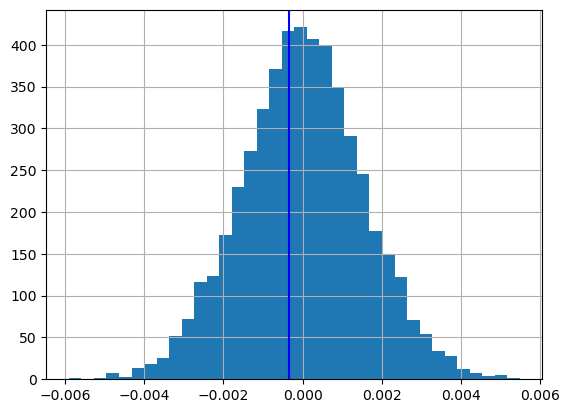

Results for WhiteRealityCheckFor1_accelerated:
average return -0.000344
uncorrected CI (log-returns, daily):  [-0.00311579  0.00296644]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.6018
What follows is the bias corrected accelerated bootstrap confidence interval (log-returns, daily).
This bias correction compensates for the fact that 
the parameter estimates from the bootstrap under- and over- estimate the true parameter (the mean return). 
Low bound, there is a 90% chance that our return is at least:  -0.0028832226301407954
High bound, there is a 90% chance that our return is at most:  0.0011875405369207873


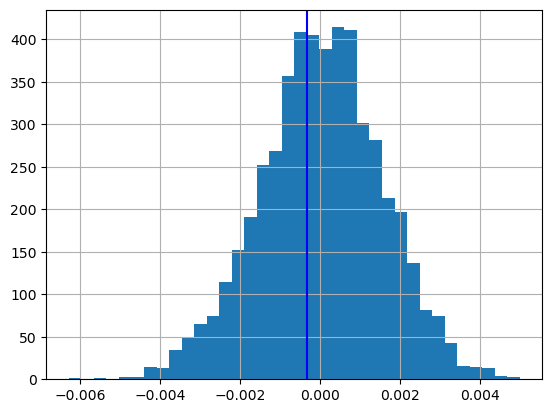

Execution time: 14.223567008972168 seconds


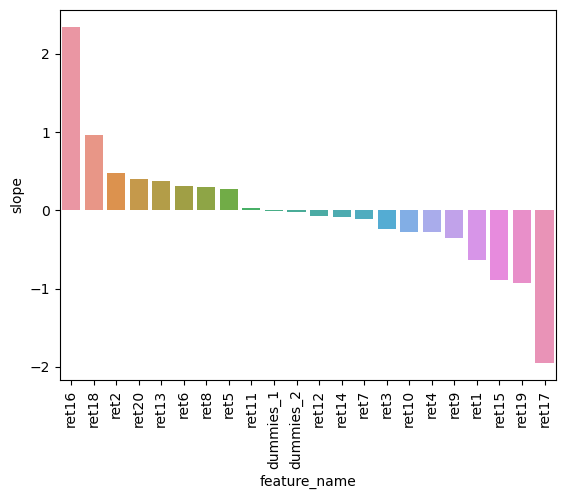

In [5]:
# Train set
# Make "predictions" on training set (in-sample)
#positions = np.where(best_model.predict(x_train)> 0,1,-1 )
positions = np.where(grid_search.predict(x_train)> 0,1,-1 ) #POSITIONS

#dailyRet = pd.Series(positions).shift(1).fillna(0).values * x_train.ret1 #for trading at the close
dailyRet = pd.Series(positions).fillna(0).values * df_train.retFut1 #for trading right after the open

dailyRet = dailyRet.fillna(0)

cumret = np.cumprod(dailyRet + 1) - 1


plt.figure(1)
plt.plot(cumret.index, cumret)
plt.title('Cross-validated LogisticRegression on currency: train set')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
#plt.show()
plt.savefig(r'Results\%s.png' %("TrainCumulative"))

    
cagr = (1 + cumret[-1]) ** (252 / len(cumret)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret)
s_ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet)
profits = np.where((dailyRet >= 0), dailyRet, 0)
losses = np.where((dailyRet < 0), dailyRet, 0)
p_ratio = np.sum(profits)/np.sum(np.abs(losses))
print (('In-sample: CAGR={:0.6} Sharpe ratio={:0.6} Profit ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}\n'\
).format(cagr, s_ratio, p_ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))

#########################################################################################################################
#########################################################################################################################    


# Test set
# Make "predictions" on test set (out-of-sample)

#positions2 = np.where(best_model.predict(x_test)> 0,1,-1 )
positions2 = np.where(grid_search.predict(x_test)> 0,1,-1 ) #POSITIONS

#dailyRet2 = pd.Series(positions2).shift(1).fillna(0).values * x_test.ret1 #for trading at the close
dailyRet2 = pd.Series(positions2).fillna(0).values * df_test.retFut1 #for trading right after the open
dailyRet2 = dailyRet2.fillna(0)

cumret2 = np.cumprod(dailyRet2 + 1) - 1

plt.figure(2)
plt.plot(cumret2.index, cumret2)
title = 'Cross-validated LogisticRegression on currency: test set'
plt.title(title)
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
#plt.show()
plt.savefig(r'Results\%s.png' %("TestCumulative"))

#metrics
acc_score = accuracy_score(y_test.values.ravel(), grid_search.predict(x_test))

#If this figure does not plot correctly select the lines and press F9 again
arr1 = y_test.values.ravel()
arr2 = grid_search.predict(x_test)
dfc = pd.DataFrame({'y_true': arr1, 'y_pred': arr2})
phi_k_corr = dfc.phik_matrix(interval_cols=[]).iloc[1,0]
significance_overview = dfc.significance_matrix(interval_cols=[])
phi_k_sig  = dfc.significance_matrix(interval_cols=[]).iloc[1,0]
phi_k_p_val = 1 - ndtr(phi_k_sig) 
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1.5, figsize=(7, 5))
plt.tight_layout()
#plt.show()
plt.savefig(r'Results\%s.png' %("PhikSignificance"))

cagr = (1 + cumret2[-1]) ** (252*8 / len(cumret2)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret2)
s_ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet2) / np.std(dailyRet2)
profits = np.where((dailyRet2 >= 0), dailyRet2, 0)
losses = np.where((dailyRet2 < 0), dailyRet2, 0)
p_ratio = np.sum(profits)/np.sum(np.abs(losses))
print (('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} Profit ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}\n'\
).format(cagr, s_ratio, p_ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))

#plot the residuals
true_y = y_test.values.ravel()
pred_y = grid_search.predict(x_test)
residuals = np.subtract(true_y, pred_y)

from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
# sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
sns.histplot(residuals, kde=True, stat='density', ax=axes[0], label='Residuals', color='blue')
axes[0].set_title('Residual Distribution')
axes[0].legend()
plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
sns.despine()
fig.tight_layout();
#plt.show()
plt.savefig(r'Results\%s.png' %("ResidualDistribution"))
plt.close("all")

#Residual autocorrelation
#If the p-value of the test is greater than the required significance (>0.05), residuals are independent
import statsmodels.api as sm
lb = sm.stats.acorr_ljungbox(residuals, lags=[10], boxpierce=False)
print("Ljung-Box test p-value", lb.iloc[0,1])

#Detrending Prices and Returns and white reality check
detrended_open = detrendPrice.detrendPrice(openp[10000:12000])
detrended_retFut1 = detrended_open.pct_change(periods=1).shift(-1).fillna(0)
detrended_syst_rets = detrended_retFut1 * pd.Series(positions2).fillna(0)
print("Results for WhiteRealityCheckFor1:")
WhiteRealityCheckFor1.bootstrap(detrended_syst_rets)
plt.show()
print("Results for WhiteRealityCheckFor1_accelerated:")
WhiteRealityCheckFor1_accelerated.bootstrap(detrended_syst_rets)
plt.show()

column_names = []
column_names = numeric_features_ix.values.tolist()
num_dummies = len(best_model[1].coef_.ravel().tolist())-len(column_names)
for i in range(1,num_dummies+1):
    column_names.append('dummies_'+str(i))

#plot the coefficients
importance = pd.DataFrame(zip(best_model[1].coef_.ravel().tolist(), column_names))
#importance = pd.DataFrame(zip(best_model[1].coef_.ravel().tolist(), x_train.columns.values.tolist()))
importance.columns = ['slope','feature_name']
importance_plot = sns.barplot(x=importance['feature_name'], y=importance['slope'], data=importance,orient='v',dodge=False,order=importance.sort_values('slope',ascending=False).feature_name)
for item in importance_plot.get_xticklabels(): #rotate the x labels by 90 degrees to avoid text overlapping
    item.set_rotation(90)
#plt.show()
plt.savefig(r'Results\%s.png' %("Coefficients"))



# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')
    

In [6]:
('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} Profit ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}\n'\
).format(cagr, s_ratio, p_ratio, maxDD, maxDDD.astype(int), -cagr/maxDD)

'Out-of-sample: CAGR=0.209547 Sharpe ratio=0.749027 Profit ratio=1.14277 maxDD=-0.0469895 maxDDD=298 Calmar ratio=4.45944\n'

In [7]:
lb.iloc[0,1]

2.2535591178549517e-31

average return -0.000344
[-0.00293225  0.0029664 ]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.5992


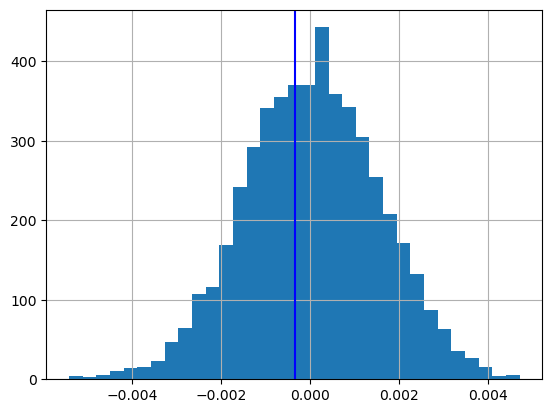

In [8]:
WhiteRealityCheckFor1.bootstrap(detrended_syst_rets)

average return -0.000344
uncorrected CI (log-returns, daily):  [-0.00302639  0.00285661]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.5848
What follows is the bias corrected accelerated bootstrap confidence interval (log-returns, daily).
This bias correction compensates for the fact that 
the parameter estimates from the bootstrap under- and over- estimate the true parameter (the mean return). 
Low bound, there is a 90% chance that our return is at least:  -0.0027010870415249497
High bound, there is a 90% chance that our return is at most:  0.0012667849835947607


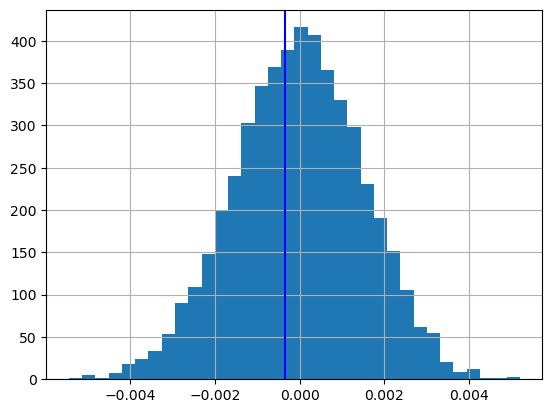

In [9]:
WhiteRealityCheckFor1_accelerated.bootstrap(detrended_syst_rets)
plt.show()